## Multiple Breakpoints

Notebook to make different subplots for the figure illustrating the basic clipped relu

In [7]:
%load_ext autoreload
%autoreload 2

import sys
import os
current_directory = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_directory, os.pardir)))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mayavi import mlab
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import CubicSpline
from lrr_annot.loader import Loader
from lrr_annot.analyzer import compute_winding, compute_regression, median_slope
from lrr_annot.plotter import plot_regression, plot_residue_annotations_3d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load in sequence, compute winding number, and compute breakpoints, assuming 2 and 3

In [42]:
protid = "AT1G72840.2"
#protid = "AT3G44400.1"
loader = Loader()
loader.load_single("../pdb", f"{protid}.pdb")
X = loader.structures[protid]
winding_res = compute_winding(X)
winding = winding_res["winding"]

regression_res_2 = compute_regression(winding, n_breakpoints=2)

left = regression_res_2['breakpoints'][0]
right = regression_res_2['breakpoints'][1]

regression_res_3 = compute_regression(winding, n_breakpoints=3)
regression_res_4 = compute_regression(winding, n_breakpoints=4, left=left, right=right)
regression_res_5 = compute_regression(winding, n_breakpoints=5)

## Plots showing what happens when we use 2 breakpoint regression

a, b 468 695
227


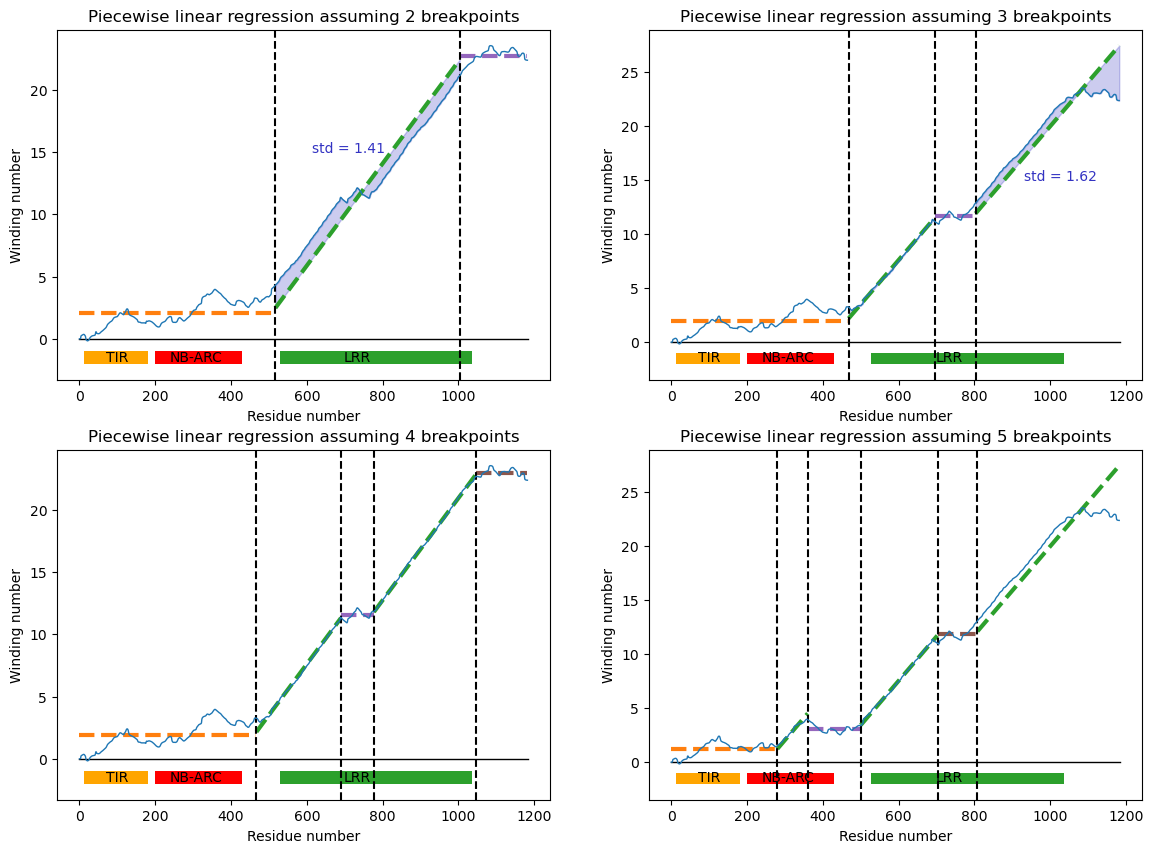

In [44]:
## Step 0: Define the domains
def draw_domains(N):
    domains = [(13, 182), (200, 429), (528, 1037)]
    colors = ['orange', 'red', 'C2']
    texts = ["TIR", "NB-ARC", "LRR"]
    rectheight = 1
    for domain, color, text in zip(domains, colors, texts):
        start, end = domain
        rect = patches.Rectangle((start, -rectheight*2), end - start, rectheight, facecolor=color)
        plt.gca().add_patch(rect)
        plt.text(start+(end-start)/len(text), -rectheight*1.8, text)
    plt.plot([0, N], [0]*2, color='k', linewidth=1)

plt.figure(figsize=(14, 10))
## Step 1: Plot 2 breakpoint results with deviation fill between
plt.subplot(221)
breakpoints = regression_res_2["breakpoints"]
slope = regression_res_2["slope"]
plot_regression(plt.gca(), winding, breakpoints, slope, colors=["C1", "C2", "C4"])
N = winding.size
draw_domains(N)
xticks = list(range(0, 1001, 200)) #+ breakpoints.tolist()
plt.xticks(xticks);
plt.yticks([0, 5, 10, 15, 20]);

[a, b] = breakpoints[0:2]
linear = slope * (np.arange(a, b) - (a + b - 1) / 2)
y = linear + np.mean(winding[a:b])
rg = np.arange(a, b)
#plt.plot(rg, winding[a:b]-y)
plt.fill_between(rg, y, winding[a:b], color=np.array([0, 0, 0.7, 0.2]))
std = np.std(winding[a:b]-y)
plt.text(a + (b-a)/5, 15, "std = {:.2f}".format(std), c=np.array([0, 0, 0.7, 0.8]))
plt.title("Piecewise linear regression assuming 2 breakpoints")

## Step 2: Plot 3 breakpoint results
plt.subplot(222)
breakpoints = regression_res_3["breakpoints"]
slope = regression_res_3["slope"]
plot_regression(plt.gca(), winding, breakpoints, slope, colors=["C1", "C2", "C4", "C2"])
draw_domains(N)

N = winding.size
[a, b] = breakpoints[0:2]
linear = slope * (np.arange(a, b) - (a + b - 1) / 2)
y1 = linear + np.mean(winding[a:b])
rg1 = np.arange(a, b)
print("a, b", a, b)
print(winding[a:b].size)
plt.fill_between(rg1, y1, winding[a:b], color=np.array([0, 0, 0.7, 0.2]))

c = breakpoints[2]
d = N
linear = slope * (np.arange(c, d) - (c + d - 1) / 2)
y2 = linear + np.mean(winding[c:d])
rg2 = np.arange(c, d)

std = np.std(winding[c:d]-y2)
plt.text(c + (d-c)/3, 15, "std = {:.2f}".format(std), c=np.array([0, 0, 0.7, 0.8]))

plt.fill_between(rg2, y2, winding[c:d], color=np.array([0, 0, 0.7, 0.2]))
plt.title("Piecewise linear regression assuming 3 breakpoints")


## Step 3: Plot 4 breakpoint results
plt.subplot(223)
breakpoints = regression_res_4["breakpoints"]
slope = regression_res_4["slope"]
plot_regression(plt.gca(), winding, breakpoints, slope, colors=["C1", "C2", "C4", "C2", "C5"])
draw_domains(N)
plt.title("Piecewise linear regression assuming 4 breakpoints")

plt.subplot(224)
breakpoints = regression_res_5["breakpoints"]
slope = regression_res_5["slope"]
plot_regression(plt.gca(), winding, breakpoints, slope, colors=["C1", "C2", "C4", "C2", "C5", "C2"])
draw_domains(N)
plt.title("Piecewise linear regression assuming 5 breakpoints")


plt.savefig("Multibreakpoint_Plots.svg", bbox_inches='tight')

## Make Plot of Annotated Regions in 3D

In [ ]:
from mayavi import mlab

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors = [int(c[1:], 16) for c in colors]
colors = [((c//65536), ((c%65536)//256), (c%256)) for c in colors]

X = loader.structures[protid]
plot_residue_annotations_3d(X, breakpoints, [colors[1], colors[2], colors[4], colors[2]])
mlab.show()